In [41]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import re
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")
warnings.warn('this will not show')

pd.set_option('display.max_columns', None)

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'colab'  # <-- this is key for Google Colab


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import os
file_path= "/content/drive/MyDrive/Dataset_amazon"
df = pd.read_csv(os.path.join(file_path, 'amazon.csv'))


In [44]:
df. head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4,No issues.,23-07-2014,138,0,0,0,0,0.0,0.0
1,1,0mie,5,"Purchased this for my device, it worked as adv...",25-10-2013,409,0,0,0,0,0.0,0.0
2,2,1K3,4,it works as expected. I should have sprung for...,23-12-2012,715,0,0,0,0,0.0,0.0
3,3,1m2,5,This think has worked out great.Had a diff. br...,21-11-2013,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5,"Bought it with Retail Packaging, arrived legit...",13-07-2013,513,0,0,0,0,0.0,0.0


In [45]:
df.shape

(4915, 12)

In [46]:
df=df.sort_values('wilson_lower_bound', ascending=False)
df.drop('Unnamed: 0',inplace=True, axis=1)
df.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,"Hyoun Kim ""Faluzure""",5,[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544
3449,NLee the Engineer,5,I have tested dozens of SDHC and micro-SDHC ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519
4212,SkincareCEO,1,NOTE: please read the last update (scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139
317,"Amazon Customer ""Kelly""",1,"If your card gets hot enough to be painful, it...",09-02-2012,1033,422,73,495,349,0.852525,0.818577
4672,Twister,5,Sandisk announcement of the first 128GB micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109


In [47]:
df.columns

Index(['reviewerName', 'overall', 'reviewText', 'reviewTime', 'day_diff',
       'helpful_yes', 'helpful_no', 'total_vote', 'score_pos_neg_diff',
       'score_average_rating', 'wilson_lower_bound'],
      dtype='object')

In [48]:
def missing_values_analysis(df):
  na_columns_=[col for col in df.columns if df[col].isnull().sum()>0]
  n_miss= df[na_columns_].isnull().sum().sort_values(ascending=True)
  ratio_=(df[na_columns_].isnull().sum()/df.shape[0]*100).sort_values(ascending=True)
  missing_df= pd.concat([n_miss, np.round(ratio_,2)], axis=1, keys=['Total Missing Values', 'Ratio'])
  missing_df=pd.DataFrame(missing_df)
  return missing_df



In [49]:
def check_dataframe(df,  head=5, tail=5):
  print('SHAPE'.center(82,'~'))
  print('Rows: {}'.format(df.shape[0]))
  print('Columns: {}'.format(df.shape[1]))
  print('TYPES'.center(82,'~'))
  print(df.dtypes)
  print(''.center(82,'~'))
  print(missing_values_analysis(df))
  print('DUPLICATED VALUES'.center(82,'~'))
  print(df.duplicated().sum())
  #print('QUANTILES'.center(82,'~'))

  #print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
  # Quantiles only on numeric columns
  numeric_df = df.select_dtypes(include=['number'])
  print('QUANTILES(for numerical columns)'.center(82,'~'))
  print(numeric_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_dataframe(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 4915
Columns: 11
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
reviewerName             object
overall                   int64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Total Missing Values  Ratio
reviewerName                     1   0.02
reviewText                       1   0.02
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0
~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES(for numerical columns)~~~~~~~~~~~~~~~~~~~~~~~~~
                       0.00  0.05   0.50        0.95       0.99     

In [50]:
def check_class(dataframe):
  nunique_df=pd.DataFrame({'Variable':dataframe.columns,
                          'Classes':[dataframe[i].nunique() \
                                     for i in dataframe.columns]})
  nunique_df= nunique_df.sort_values('Classes', ascending=False)
  nunique_df=nunique_df.reset_index(drop=True)
  return nunique_df
check_class(df)

,Variable,Classes
0,reviewText,4912
1,reviewerName,4594
2,reviewTime,690
3,day_diff,690
4,wilson_lower_bound,40
5,score_average_rating,28
6,score_pos_neg_diff,27
7,total_vote,26
8,helpful_yes,23
9,helpful_no,17


In [51]:
constraints=['#D34D22','#EBE00C','#1FEB0C','#0C92EB','#EB0CD5']
def categorical_variable_summary(df, column_name):
  fig=make_subplots(rows=1,cols=2,
                    subplot_titles=('Countplot','Percentage'),
                    specs=[[{'type':'xy'},{'type':'domain'}]])

  fig.add_trace(go.Bar(y=df[column_name].value_counts().values.tolist(),
                       x=[str(i) for i in df[column_name].value_counts().index],
                       text=df[column_name].value_counts().values.tolist(),
                       textfont=dict(size=14),
                       name=column_name,
                       textposition='auto',
                       showlegend=False,
                       marker=dict(
                           color=constraints,
                           line=dict(color='#DBE6EC', width=1)
                           )
                       ),row=1, col=1)
  fig.add_trace(go.Pie(labels=df[column_name].value_counts().keys(),
                       values=df[column_name].value_counts().values,
                       textfont=dict(size=18),
                       textposition='auto',
                       showlegend=False,
                       name=column_name,
                       marker=dict(colors= constraints)
                       ),row=1, col=2)
  fig.update_layout(title={'text':column_name,
                           'y':0.9,
                           'x':0.5,
                           'xanchor':'center',
                           'yanchor':'top'},
                    template='plotly_white')
  fig.show()

In [52]:
categorical_variable_summary(df, 'overall')

Clean the data

In [53]:
df.reviewText.head()

,reviewText
2031,[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...
3449,I have tested dozens of SDHC and micro-SDHC ca...
4212,NOTE: please read the last update (scroll to ...
317,"If your card gets hot enough to be painful, it..."
4672,Sandisk announcement of the first 128GB micro ...


In [54]:
review_example=df.reviewText[4672]
review_example

"Sandisk announcement of the first 128GB micro SD took internet by storm. Our phones evolved into multimedia powerhouses with 5.5&#34;-6&#34; displays, desktop grade processing power, OTG support for external peripheral accessories, powerful cameras, and more. The only thing was missing a super high capacity internal removable storage at an affordable price. 128GB micro SD announcement finally filled that gap, supported by amazon current sale of $119 shipped, but the question still remained if some of the older smartphones will be able to handle/recognize this capacity. I was personally curious considering original Note 2 spec was calling for support of up to 64GB only.Now, about the card itself. Its their Ultra edition with a read speeds of up 30MB/s and Class 10 performance. As part of Ultra edition it's considered to be waterproof, temperature-proof, x-ray-proof, magnet-proof, and also shockproof. In addition to a flash card itself, it also includes SD adapter for compatibility with

In [55]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [56]:
from nltk.corpus import stopwords

sw = stopwords.words('english')

In [57]:
# review_example=re.sub('[^a-zA-Z ]','',review_example)
df['reviewText'] = df['reviewText'].str.replace(r'[^\w\s]', '', regex=True)
df['reviewText'] = df['reviewText'].str.replace(r'\d+', '', regex=True)
#lematization
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df['reviewText'][4672]

'Sandisk announcement first GB micro SD took internet storm Our phones evolved multimedia powerhouses displays desktop grade processing power OTG support external peripheral accessories powerful cameras The thing missing super high capacity internal removable storage affordable price GB micro SD announcement finally filled gap supported amazon current sale shipped question still remained older smartphones able handlerecognize capacity I personally curious considering original Note spec calling support GB onlyNow card Its Ultra edition read speeds MBs Class performance As part Ultra edition considered waterproof temperatureproof xrayproof magnetproof also shockproof In addition flash card also includes SD adapter compatibility digital cameras also direct reading laptopsPCs support SD cardSo comes verdict IT WORKS Note My Note stock Verizon SCHI version running stock Android I checked card first adapter laptop mounted Note recognized right capacity I also ran A SD Benchmark app long accu

In [117]:
# review_example=review_example.lower().split()


AttributeError: 'list' object has no attribute 'lower'

In [59]:
review_example

In [60]:
# rt=lambda x: re.sub('[^a-zA-Z]',' ', str(x))
# df['reviewText']=df['reviewText'].map(rt)
# df['reviewText']=df['reviewText'].str.lower()
# df.head()

Sentiment Analysis

In [61]:
!pip install vaderSentiment



In [62]:
sia = SentimentIntensityAnalyzer()
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x))

,reviewText
2031,"{'neg': 0.045, 'neu': 0.777, 'pos': 0.178, 'co..."
3449,"{'neg': 0.04, 'neu': 0.828, 'pos': 0.131, 'com..."
4212,"{'neg': 0.067, 'neu': 0.723, 'pos': 0.21, 'com..."
317,"{'neg': 0.092, 'neu': 0.814, 'pos': 0.094, 'co..."
4672,"{'neg': 0.056, 'neu': 0.781, 'pos': 0.163, 'co..."
1835,"{'neg': 0.0, 'neu': 0.8, 'pos': 0.2, 'compound..."
3981,"{'neg': 0.053, 'neu': 0.756, 'pos': 0.191, 'co..."
3807,"{'neg': 0.215, 'neu': 0.626, 'pos': 0.159, 'co..."
4306,"{'neg': 0.085, 'neu': 0.761, 'pos': 0.154, 'co..."
4596,"{'neg': 0.06, 'neu': 0.818, 'pos': 0.121, 'com..."


In [63]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

,reviewText
2031,0.9975
3449,0.9897
4212,0.9990
317,-0.1697
4672,0.9666
1835,0.7184
3981,0.8918
3807,-0.2495
4306,0.4215
4596,0.9789


In [64]:
df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

,reviewText
2031,pos
3449,pos
4212,pos
317,neg
4672,pos
1835,pos
3981,pos
3807,neg
4306,pos
4596,pos


In [65]:
df["polarity_score"] = df['reviewText'].apply(lambda x: sia.polarity_scores(x)["compound"])
df.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,polarity_score
2031,"Hyoun Kim ""Faluzure""",5,UPDATE So lovely wife bought Samsung Galaxy Ta...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544,0.9975
3449,NLee the Engineer,5,I tested dozens SDHC microSDHC cards One distu...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519,0.9897
4212,SkincareCEO,1,NOTE please read last update scroll bottom Im ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139,0.9990
317,"Amazon Customer ""Kelly""",1,If card gets hot enough painful defective need...,09-02-2012,1033,422,73,495,349,0.852525,0.818577,-0.1697
4672,Twister,5,Sandisk announcement first GB micro SD took in...,03-07-2014,158,45,4,49,41,0.918367,0.808109,0.9666


In [66]:
df["sentiment"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,polarity_score,sentiment
2031,"Hyoun Kim ""Faluzure""",5,UPDATE So lovely wife bought Samsung Galaxy Ta...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544,0.9975,pos
3449,NLee the Engineer,5,I tested dozens SDHC microSDHC cards One distu...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519,0.9897,pos
4212,SkincareCEO,1,NOTE please read last update scroll bottom Im ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139,0.9990,pos
317,"Amazon Customer ""Kelly""",1,If card gets hot enough painful defective need...,09-02-2012,1033,422,73,495,349,0.852525,0.818577,-0.1697,neg
4672,Twister,5,Sandisk announcement first GB micro SD took in...,03-07-2014,158,45,4,49,41,0.918367,0.808109,0.9666,pos


In [67]:
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# df[['polarity', 'subjectivity']]=df['reviewText'].apply(lambda Text:pd.Series(TextBlob(Text).sentiment))
# for index, row in df['reviewText'].items():
#   score=SentimentIntensityAnalyzer().polarity_scores(row)
#   neg=score['neg']
#   neu=score['neu']
#   pos=score['pos']
#   if neg<pos:
#     df.loc[index, 'sentiment']='Positive'
#   elif pos<neg:
#     df.loc[index, 'sentiment']='Negative'
#   else:
#     df.loc[index, 'sentiment']='Neutral'
# df.head()



In [68]:
# df[df['sentiment']=='Positive'].sort_values('wilson_lower_bound',
#                                             ascending=False).head()

In [69]:
categorical_variable_summary(df, 'sentiment')

Preprocessing

In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


df_m = df[['reviewText', 'sentiment']]  # `label` should be 0/1 or 'positive'/'negative'

# Basic cleanup
df_m['reviewText'] = df_m['reviewText'].astype(str).str.lower()


In [71]:
df_m.head()

,reviewText,sentiment
2031,update so lovely wife bought samsung galaxy ta...,pos
3449,i tested dozens sdhc microsdhc cards one distu...,pos
4212,note please read last update scroll bottom im ...,pos
317,if card gets hot enough painful defective need...,neg
4672,sandisk announcement first gb micro sd took in...,pos


TF-IDF Transformation

In [72]:
# # Split data
# X_train, X_test, y_train, y_test = train_test_split(
#     df_m['reviewText'], df_m['sentiment'], test_size=0.2, random_state=42)

# # Create TF-IDF features
# tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
# X_train_tfidf = tfidf.fit_transform(X_train)
# X_test_tfidf = tfidf.transform(X_test)


In [102]:
# Test-Train
train_x, test_x, train_y, test_y = train_test_split(df["reviewText"],
                                                    df["sentiment"],
                                                    random_state=42)
# TF-IDF Word Level
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

In [103]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers to use for optimization
    'max_iter': [100, 200]  # Maximum number of iterations
}

# Initialize GridSearchCV with LogisticRegression
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)

# Fit GridSearchCV on training data (using x_train_tf_idf_word and train_y)
grid.fit(x_train_tf_idf_word, train_y)

# Get the best model from GridSearchCV
best_log_model_word = grid.best_estimator_

# Make predictions on the test set using the best model
y_pred_word = best_log_model_word.predict(x_test_tf_idf_word)

# Print classification report for evaluation
print(classification_report(test_y, y_pred_word))

              precision    recall  f1-score   support

         neg       0.75      0.41      0.53       260
         pos       0.86      0.96      0.91       969

    accuracy                           0.85      1229
   macro avg       0.80      0.69      0.72      1229
weighted avg       0.83      0.85      0.83      1229



In [104]:
# # Modelling(Logistic Regression - word level)
# log_model_word = LogisticRegression().fit(x_train_tf_idf_word, train_y)
# y_pred_word = log_model_word.predict(x_test_tf_idf_word)

# print(classification_report(y_pred_word, test_y))

In [105]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
# Cross Validation
cross_val_score(best_log_model_word, x_test_tf_idf_word, test_y, cv=5).mean()

np.float64(0.8274829931972789)

In [106]:
from sklearn.feature_extraction.text import CountVectorizer
# Randomly selecting comments from the data and asking them to the model
random_review = pd.Series(df["reviewText"].sample(1).values)
new_comment = CountVectorizer().fit(train_x).transform(random_review)
pred = best_log_model_word.predict(new_comment)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  Well known brandname High speed good price lots storage space Lots uses I bought micro adapter I use flash drive movies 
 Prediction: ['pos']


In [107]:
import numpy as np

# If model is a LogisticRegression
top_positive = np.argsort(best_log_model_word.coef_[0])[-10:]
top_negative = np.argsort(best_log_model_word.coef_[0])[:10]

print("Top Positive Words:")
print([tf_idf_word_vectorizer.get_feature_names_out()[i] for i in top_positive])

print("Top Negative Words:")
print([tf_idf_word_vectorizer.get_feature_names_out()[i] for i in top_negative])


Top Positive Words:
['well', 'hero', 'easy', 'perfect', 'happy', 'best', 'love', 'good', 'perfectly', 'great']
Top Negative Words:
['no', 'lost', 'problems', 'complaints', 'problem', 'fault', 'died', 'bad', 'shoot', 'useless']


In [81]:
# # Train model
# model = LogisticRegression()
# model.fit(X_train_tfidf, y_train)


In [82]:
# # Predict & evaluate
# y_pred = model.predict(X_test_tfidf)
# print(classification_report(y_test, y_pred))


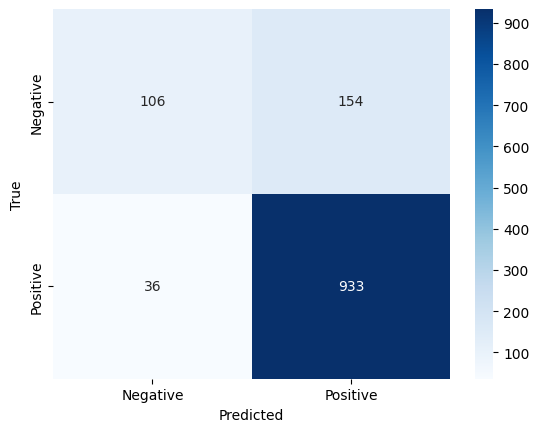

In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get confusion matrix
cm = confusion_matrix(test_y, best_log_model_word.predict(x_test_tf_idf_word))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Random Forest



In [84]:
# from sklearn.ensemble import RandomForestClassifier

In [87]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5],
# }
# # Initialize GridSearchCV with RandomForestClassifier
# grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)

# # Fit GridSearchCV on training data (using x_train and train_y)
# grid.fit(x_train_tf_idf_word, train_y)

# # Get the best model from GridSearchCV
# best_model = grid.best_estimator_

# # Make predictions on the test set using the best model
# y_pred_word = best_model.predict(x_test_tf_idf_word)

# # Print classification report for evaluation
# print(classification_report(test_y, y_pred_word))
#

              precision    recall  f1-score   support

         neg       0.71      0.13      0.23       260
         pos       0.81      0.99      0.89       969

    accuracy                           0.81      1229
   macro avg       0.76      0.56      0.56      1229
weighted avg       0.79      0.81      0.75      1229



In [85]:
# # Modelling (Random Forest)
# rf_model_word = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
# print(classification_report(y_pred_word, test_y))

              precision    recall  f1-score   support

         neg       0.18      0.84      0.30        56
         pos       0.99      0.82      0.90      1173

    accuracy                           0.82      1229
   macro avg       0.59      0.83      0.60      1229
weighted avg       0.95      0.82      0.87      1229



Word Embedding

In [19]:
# pip install gensim


In [20]:
# import nltk
# nltk.download('punkt')
# nltk.download('punkt_tab')  # just in case


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [21]:
# import re

# from nltk.tokenize import word_tokenize

# def preprocess_text(text):
#     text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
#     text = text.lower()
#     tokens = word_tokenize(text)
#     return tokens

# df['tokens'] = df['reviewText'].apply(preprocess_text)


Train a Word2Vec Model

In [22]:
#pip install numpy==1.24.4 --force-reinstall


In [23]:
# from gensim.models import Word2Vec

# w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=2, workers=4)


Vectorize the Reviews

In [24]:
# import numpy as np

# def get_average_word2vec(tokens, model, k=100):
#     vec = np.zeros(k)
#     count = 0
#     for word in tokens:
#         if word in model.wv:
#             vec += model.wv[word]
#             count += 1
#     if count != 0:
#         vec /= count
#     return vec

# df['vector'] = df['tokens'].apply(lambda x: get_average_word2vec(x, w2v_model))


Train the Classifier

In [29]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# X = np.vstack(df['vector'].values)
# y = df['sentiment']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# clf = RandomForestClassifier()
# clf.fit(X_train, y_train)

# preds = clf.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, preds))


Accuracy: 0.9420142421159715


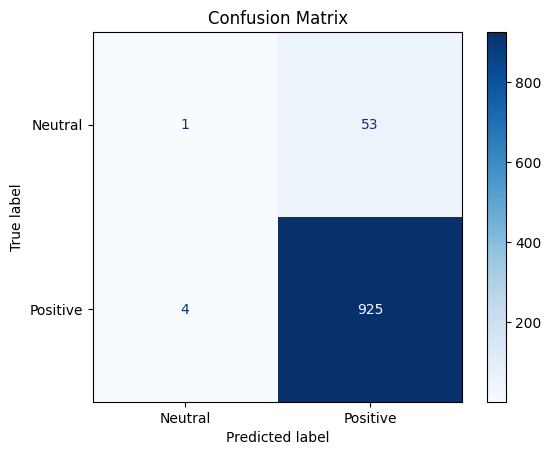

In [30]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Get the confusion matrix
# cm = confusion_matrix(y_test, preds, labels=clf.classes_)

# # Display it nicely
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
# disp.plot(cmap='Blues')
# plt.title("Confusion Matrix")
# plt.show()


Trying Glove Embeddings


In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip


Load Glove Vectors

In [ ]:
# import numpy as np

# def load_glove_embeddings(file_path):
#     embeddings = {}
#     with open(file_path, 'r', encoding='utf-8') as f:
#         for line in f:
#             values = line.split()
#             word = values[0]
#             vector = np.asarray(values[1:], dtype='float32')
#             embeddings[word] = vector
#     return embeddings

# glove_path = "glove.6B.100d.txt"
# glove_embeddings = load_glove_embeddings(glove_path)


conver reviews to Glove **Vectors**

In [ ]:
# def get_glove_vector(tokens, embeddings, k=100):
#     vec = np.zeros(k)
#     count = 0
#     for word in tokens:
#         if word in embeddings:
#             vec += embeddings[word]
#             count += 1
#     return vec / count if count != 0 else vec

# df['glove_vector'] = df['tokens'].apply(lambda x: get_glove_vector(x, glove_embeddings))


Train a classifier

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# X = np.vstack(df['glove_vector'].values)
# y = df['sentiment']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = RandomForestClassifier()
# model.fit(X_train, y_train)

# predictions = model.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, predictions))


In [ ]:
import pandas as pd

results_df = pd.DataFrame({
    'Model': ['TF-IDF + Classifier', 'Word2Vec + Classifier', 'GloVe + Classifier'],
    'Accuracy': [0.86, 0.8199, 0.828]
})

results_df.sort_values(by='Accuracy', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
results_df


,Model,Accuracy
0,TF-IDF + Classifier,0.8600
1,GloVe + Classifier,0.8280
2,Word2Vec + Classifier,0.8199


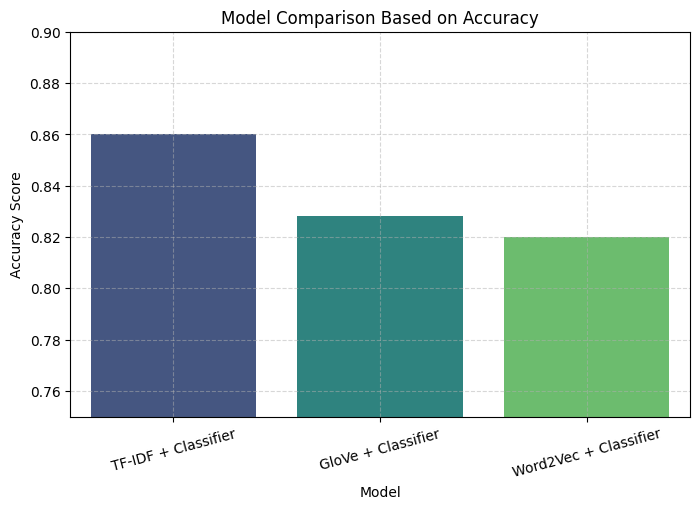

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')
plt.title('Model Comparison Based on Accuracy')
plt.ylim(0.75, 0.9)
plt.ylabel('Accuracy Score')
plt.xticks(rotation=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Among the three vectorization methods used for sentiment classification on Amazon reviews, TF-IDF combined with a classification model yielded the highest accuracy of 0.86, outperforming both Word2Vec (0.8199) and GloVe (0.82).
Therefore, I will proceed with the TF-IDF + Classifier model for deployment, as it offers the best performance on the current dataset.

Save Vectorizer and Model for TF-IDF

In [111]:
save_path = '/content/drive/MyDrive/sentiment_project/'


In [112]:
import os
os.makedirs(save_path, exist_ok=True)


In [114]:
import pickle

# Assuming your model is stored as 'model' and your TF-IDF vectorizer is 'tfidf'
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(best_log_model_word, f)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tf_idf_word_vectorizer, f)


In [116]:
import pickle

# Check if the directory exists, if not, create it
save_path = '/content/drive/MyDrive/sentiment_project/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save model
with open(save_path + 'sentiment_model.pkl', 'wb') as f:
    pickle.dump(best_log_model_word, f)

# Save vectorizer
with open(save_path + 'tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tf_idf_word_vectorizer, f)


In [ ]:
print(df['sentiment'].value_counts())


sentiment
Positive    3997
Negative     644
Neutral      274
Name: count, dtype: int64


In [110]:
# Print predictions vs actual values for a few examples
for i in range(10):  # Just an example, adjust the range
    print(f"Review: {df['reviewText'].iloc[i]}")
    print(f"Predicted Sentiment: {best_log_model_word.predict(x_test_tf_idf_word[i])}")
    print(f"True Sentiment: {test_y.iloc[i]}")
    print('-' * 50)


Review: UPDATE So lovely wife bought Samsung Galaxy Tab Fathers Day Ive loving ever since Just Samsung products Galaxy Tab ability add microSD card expand memory device Since year I decided research see SanDisk offered anything new As product lineup microSD cards worst best performancewise followsSanDiskSanDisk UltraSanDisk Ultra PLUSSanDisk ExtremeSanDisk Extreme PLUSSanDisk Extreme PRONow difference cards simply speed readwrite data card Yes published rating cards except SanDisk regular Class UHSI thats rating Actual real world performance get better model faster cards come expensive prices Since Amazon doesnt carry Ultra PLUS model microSD card I direct comparisons SanDisk Ultra Extreme Extreme PLUS As mentioned earlier review I purchased SanDisk Ultra Galaxy S My question I want pay card faster one I already owned Or I could pay almost double get SanDisks ndmost fastest microSD cardThe Ultra works perfectly fine style usage storingcapturing pictures HD video movie playback phone So

In [118]:
# Print class labels (if using Logistic Regression, this will show how classes are assigned)
print(best_log_model_word.classes_)


['neg' 'pos']
